In [14]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd

In [15]:
hyperparams = {
    'netifier': {
        'path': '../multi-label-active-learning/dataset/netifier/data/train.csv',
        'sequence_length': 96,
        'data_count': 7773,
        'batch_size': 32,
        'text_col': 6,
        'label_col_start': 2,
        'label_col_end': 6,
        'labels': ['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        'model_index': {
            'lc': 1,
            'mc': 1,
            'kmeans': 4,
            'coreset': 2,
            'besra': 3,
            'comal': 1,
            'random': 1,
        }
    },
    'dat': {
        'path': '../multi-label-active-learning/dataset/Doctors Answer Text Dataset in Indonesian Contains Information on Medical Interview Patterns/Indo-Online Health Consultation-Medical Interview-Clean.csv',
        'sequence_length': 192,
        'data_count': 500,
        'batch_size': 4,
        'text_col': 8,
        'label_col_start': 2,
        'label_col_end': 8,
        'labels': ['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE'],
        'model_index': {
            'lc': 4,
            'mc': 5,
            'kmeans': 5,
            'coreset': 2,
            'besra': 2,
            'comal': 5,
            'random': 2,
        }
    },
    'hsd': {
        'path': '../multi-label-active-learning/dataset/id-multi-label-hate-speech-and-abusive-language-detection/re_dataset.csv',
        'sequence_length': 80,
        'data_count': 13169,
        'batch_size': 64,
        'text_col': 0,
        'label_col_start': 1,
        'labels': ['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        'model_index': {
            'lc': 3,
            'mc': 2,
            'kmeans': 5,
            'coreset': 4,
            'besra': 5,
            'comal': 1,
            'random': 4,
        }
    },
    'casa': {
        'path': '../multi-label-active-learning/dataset/CASA/test_preprocess.csv',
        'sequence_length': 48,
        'data_count': 1080,
        'batch_size': 16,
        'text_col': 0,
        'label_col_start': 1,
        'aspects': ['fuel', 'machine', 'others', 'part', 'price', 'service'],
        'model_index': {
            'lc': 1,
            'mc': 2,
            'kmeans': 3,
            'coreset': 3,
            'besra': 3,
            'comal': 5,
            'random': 2,
        }
    },
    'hoasa': {
        'path': '../multi-label-active-learning/dataset/HoASA/test_preprocess.csv',
        'sequence_length': 48,
        'data_count': 2854,
        'batch_size': 16,
        'text_col': 0,
        'label_col_start': 1,
        'aspects': ['ac', 'air_panas', 'bau', 'general', 'kebersihan', 'linen', 'service', 'sunrise_meal', 'tv', 'wifi'],
        'model_index': {
            'lc': 5,
            'mc': 3,
            'kmeans': 4,
            'coreset': 1,
            'besra': 1,
            'comal': 4,
            'random': 5,
        }
    },
}

strategies = ['LC', 'MC', 'Coreset', 'KMeans', 'BESRA', 'CoMAL', 'Random']

def get_dataset_hyperparameters(dataset: str):
    return hyperparams[dataset] if dataset in hyperparams else None

In [16]:
def load_data(dataset, query_strategy, percentage):
    hyperparams = get_dataset_hyperparameters(dataset)
    if percentage <= 0.5:
        data_count = int(math.floor(0.5 * hyperparams['data_count']))
    else:
        data_count = int(math.floor(percentage * hyperparams['data_count']))
    max_data_count = int(math.floor(0.8 * hyperparams['data_count']))
    acq_data = pd.read_csv(f'./../{dataset}/acquired_data/{dataset}-{query_strategy}-1-data-{data_count}.csv')
    ori_data = pd.read_csv(f'./../{dataset}/acquired_data/{dataset}-lc-1-data-{max_data_count}.csv')

    acq_data = acq_data.iloc[:int(math.floor(percentage * hyperparams['data_count']))]
    ori_data = ori_data.iloc[:max_data_count]

    label_columns = acq_data.columns[1:]

    return acq_data, ori_data, label_columns

In [17]:
def count_label_occurences(df, labels, label_to_find=1, subclasses=None):
    if subclasses is not None:
        count = {label: {subclass: 0 for subclass in subclasses} for label in labels}
    else:
        count = {label: 0 for label in labels}

    for i in range(df.shape[0]):
        data = df.iloc[i]
        for label in labels:
            if subclasses:
                if type(data[label]) != str:
                    continue
                count[label][data[label]] += 1
            elif data[label] == label_to_find:
                count[label] += 1

    return count

In [18]:
def count_difference(acq_data, ori_data, label_columns, subclasses=None, label_to_find=1):
    acq_label_count = count_label_occurences(acq_data, label_columns, label_to_find, subclasses)
    print(acq_label_count)

    ori_label_count = count_label_occurences(ori_data, label_columns, label_to_find, subclasses)
    print(ori_label_count)

    if subclasses is not None:
        difference = {
            label: {subclass: ori_label_count[label][subclass] - acq_label_count[label][subclass] for subclass in subclasses} 
            for label in label_columns
        }
    else:
        difference = {
            'acquired': [acq_label_count[label] for label in label_columns],
            'difference': [ori_label_count[label] - acq_label_count[label] for label in label_columns],
        }

    return acq_label_count, ori_label_count, difference

In [19]:
# Function to calculate imbalance ratio for a column
def calculate_imbalance_ratio(column):
    value_counts = column.value_counts()
    value_counts.drop('neg_pos', inplace=True, errors='ignore')

    max_count = value_counts.max()
    min_count = value_counts.min()

    return max_count / min_count if min_count > 0 else float('inf')

In [20]:
def plot_acquired_data(differences, label_columns):
    # Create 7 subplots
    fig, axes = plt.subplots(4, 2, figsize=(12, 12), constrained_layout=True, sharex=True)
    x = np.arange(len(label_columns))

    for i, strategy in enumerate(strategies):
        ax = axes[i // 2, i % 2]

        rects1 = ax.bar(label_columns, differences[i]['acquired'], label='Acquired', width=0.4)
        rects2 = ax.bar(label_columns, differences[i]['difference'], bottom=differences[i]['acquired'], label='Original', width=0.4)

        ax.bar_label(rects1, padding=6)
        ax.bar_label(rects2, padding=6)

        ax.set_xlabel('Categories')
        ax.set_ylabel('Counts')
        ax.set_xticks(x)
        ax.set_xticklabels(label_columns, rotation=45)
        ax.set_title(strategy.upper())
        ax.legend()

    axes.flat[-1].axis('off')
    plt.show()

In [21]:
def plot_acquired_data_2(acq_label_count, differences, label_columns):
    # Create 7 subplots
    fig, axes = plt.subplots(4, 2, figsize=(15, 15), constrained_layout=True, sharex=True)
    x = np.arange(len(label_columns))

    for i, strategy in enumerate(strategies):
        x = np.arange(0, 10)
        width = 0.25  # Width of each bar
        multiplier = 0

        ax = axes[i // 2, i % 2]  # Get the current subplot

        diff_counts = {
            'negative': [],
            'neutral': [],
            'positive': [],
        }
        acq_counts = {
            'negative': [],
            'neutral': [],
            'positive': [],
        }

        for j, label in enumerate(label_columns):
            diff_counts['negative'].append(differences[i][label]['neg'])
            diff_counts['neutral'].append(differences[i][label]['neut'])
            diff_counts['positive'].append(differences[i][label]['pos'])
            acq_counts['negative'].append(acq_label_count[i][label]['neg'])
            acq_counts['neutral'].append(acq_label_count[i][label]['neut'])
            acq_counts['positive'].append(acq_label_count[i][label]['pos'])

        for attribute, measurement in diff_counts.items():
            offset = width * multiplier
            rects1 = ax.bar(x + offset, acq_counts[attribute], width, label="Acquired", color='#1f77b4')
            rects2 = ax.bar(x + offset, measurement, width, label='Original', bottom=acq_counts[attribute], color='#ff7f0e')

            ax.bar_label(rects1, padding=6)
            # ax.bar_label(rects2, padding=6)
            multiplier += 1
        
        ax.set_xlabel('Categories')
        ax.set_ylabel('Counts')
        ax.set_xticks(x)
        ax.set_xticklabels(label_columns, rotation=45)
        ax.set_title(strategy.upper())
        
    axes.flat[-1].axis('off')
    plt.show()

Processing strategy: LC
{'ac': {'neg': 290, 'pos': 44, 'neut': 1092, 'neg_pos': 1}, 'air_panas': {'neg': 227, 'pos': 21, 'neut': 1179, 'neg_pos': 0}, 'bau': {'neg': 240, 'pos': 11, 'neut': 1176, 'neg_pos': 0}, 'general': {'neg': 20, 'pos': 164, 'neut': 1243, 'neg_pos': 0}, 'kebersihan': {'neg': 363, 'pos': 158, 'neut': 901, 'neg_pos': 5}, 'linen': {'neg': 363, 'pos': 54, 'neut': 1009, 'neg_pos': 1}, 'service': {'neg': 235, 'pos': 187, 'neut': 1004, 'neg_pos': 1}, 'sunrise_meal': {'neg': 80, 'pos': 66, 'neut': 1281, 'neg_pos': 0}, 'tv': {'neg': 135, 'pos': 11, 'neut': 1281, 'neg_pos': 0}, 'wifi': {'neg': 239, 'pos': 21, 'neut': 1167, 'neg_pos': 0}}
{'ac': {'neg': 417, 'pos': 51, 'neut': 1814, 'neg_pos': 1}, 'air_panas': {'neg': 335, 'pos': 26, 'neut': 1922, 'neg_pos': 0}, 'bau': {'neg': 360, 'pos': 12, 'neut': 1911, 'neg_pos': 0}, 'general': {'neg': 30, 'pos': 230, 'neut': 2023, 'neg_pos': 0}, 'kebersihan': {'neg': 722, 'pos': 205, 'neut': 1350, 'neg_pos': 6}, 'linen': {'neg': 606, 'pos

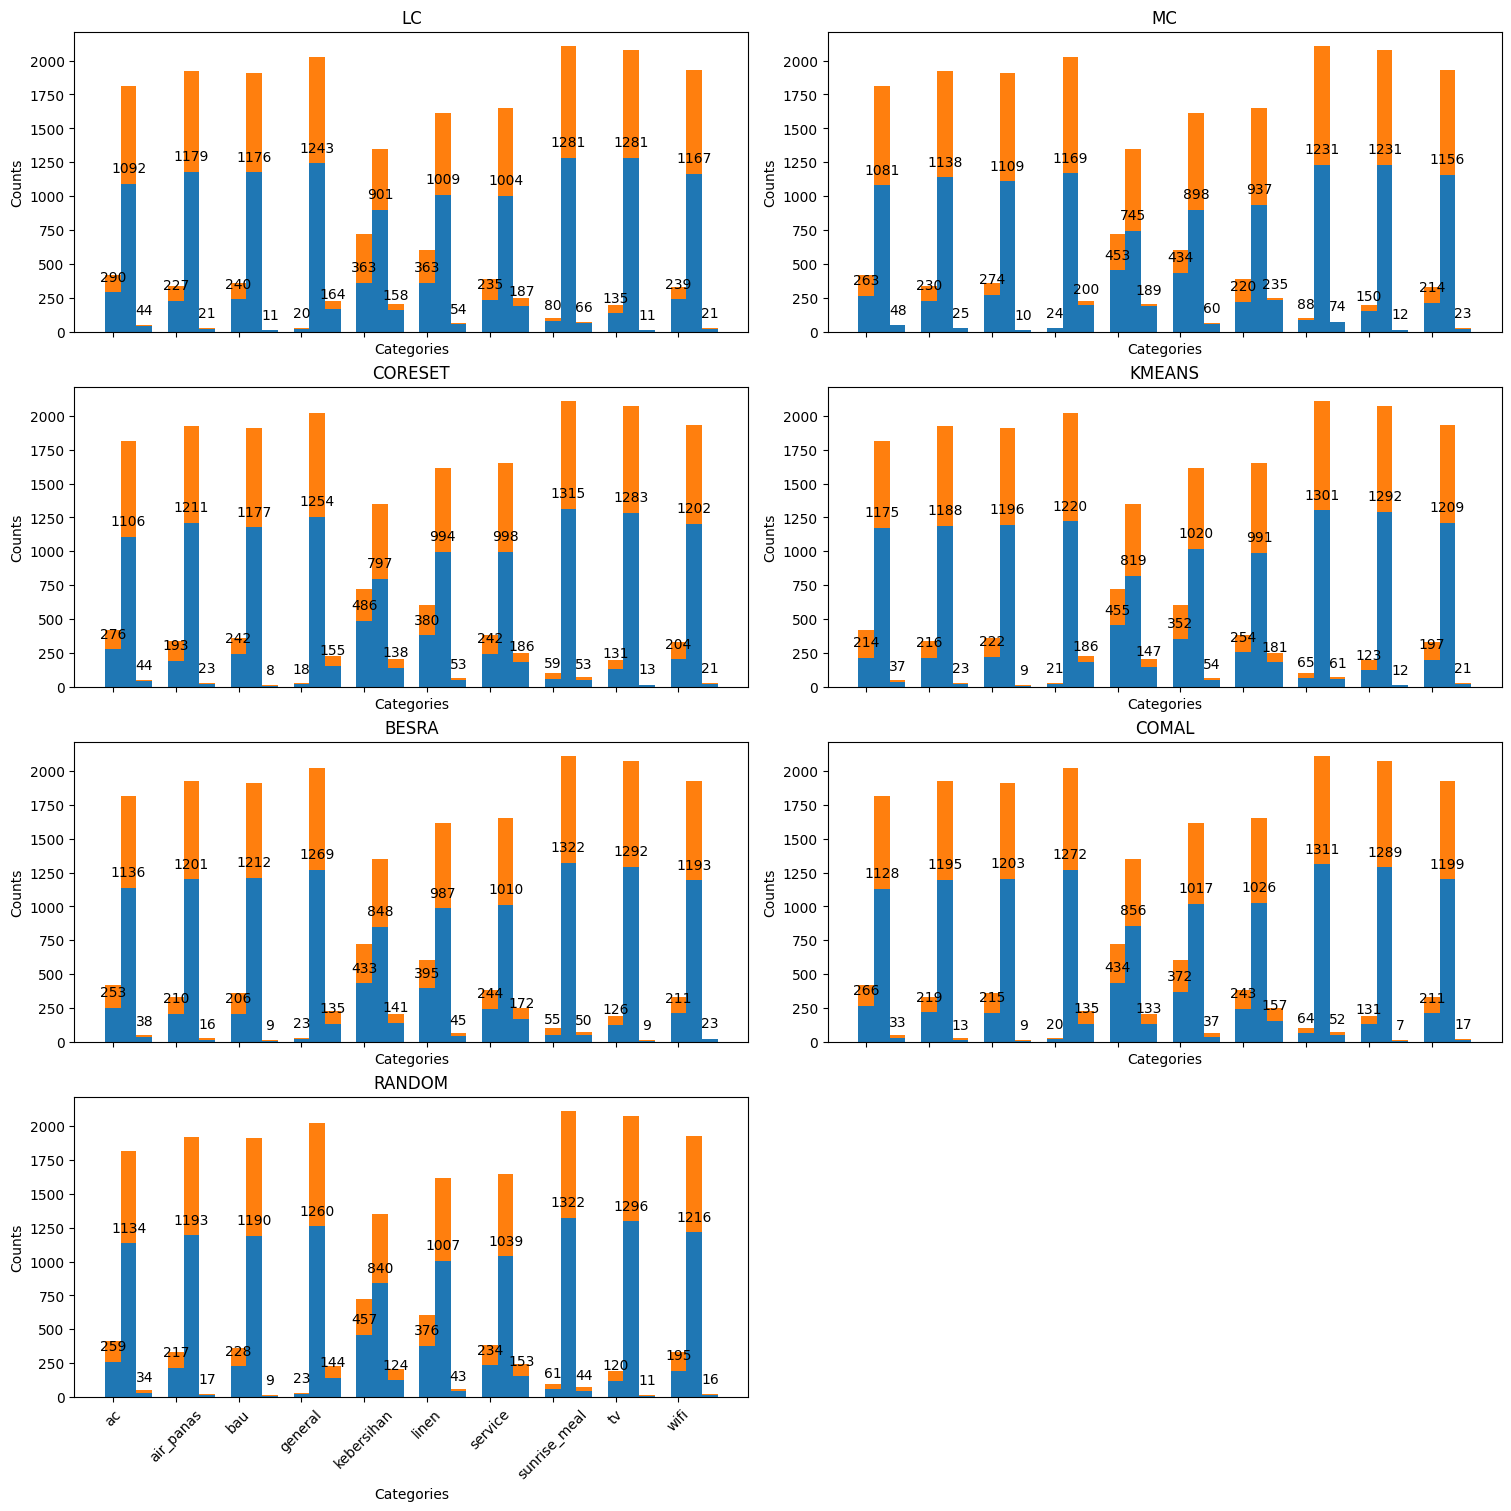

In [36]:
differences = []
all_acq_label_counts = []

for strategy in strategies:
    print(f"Processing strategy: {strategy}")
    acq_data, ori_data, label_columns = load_data('hoasa', strategy.lower(), 0.5)
    acq_label_count, ori_label_count, difference = count_difference(acq_data, ori_data, label_columns, subclasses=['neg', 'pos', 'neut', 'neg_pos'])
    differences.append(difference)
    all_acq_label_counts.append(acq_label_count)

    # print(difference)

    # Specify the columns to analyze
    columns_to_analyze = hyperparams['hoasa']['aspects']

    # Calculate imbalance ratios for each column
    imbalance_ratios = {col: calculate_imbalance_ratio(acq_data[col]) for col in columns_to_analyze}

    # Calculate the mean imbalance ratio
    mean_imbalance_ratio = round(sum(imbalance_ratios.values()) / len(imbalance_ratios), 2)

    # Print the results
    print("Mean Imbalance Ratio:", mean_imbalance_ratio)
    print("-----------------------------------------------------")

plot_acquired_data_2(all_acq_label_counts, differences, label_columns)

Processing strategy: LC
{'pornografi': 295, 'sara': 450, 'radikalisme': 443, 'pencemaran_nama_baik': 859}
{'pornografi': 1385, 'sara': 1001, 'radikalisme': 1041, 'pencemaran_nama_baik': 1933}
Imbalance Ratios for each column: {'pornografi': 12.172881355932203, 'sara': 7.635555555555555, 'radikalisme': 7.772009029345372, 'pencemaran_nama_baik': 3.5238649592549476}
Mean Imbalance Ratio: 7.78
-----------------------------------------------------
Processing strategy: MC
{'pornografi': 632, 'sara': 871, 'radikalisme': 893, 'pencemaran_nama_baik': 1649}
{'pornografi': 1385, 'sara': 1001, 'radikalisme': 1041, 'pencemaran_nama_baik': 1933}
Imbalance Ratios for each column: {'pornografi': 5.14873417721519, 'sara': 3.4615384615384617, 'radikalisme': 3.3516237402015676, 'pencemaran_nama_baik': 1.356579745300182}
Mean Imbalance Ratio: 3.33
-----------------------------------------------------
Processing strategy: Coreset
{'pornografi': 1283, 'sara': 700, 'radikalisme': 780, 'pencemaran_nama_baik':

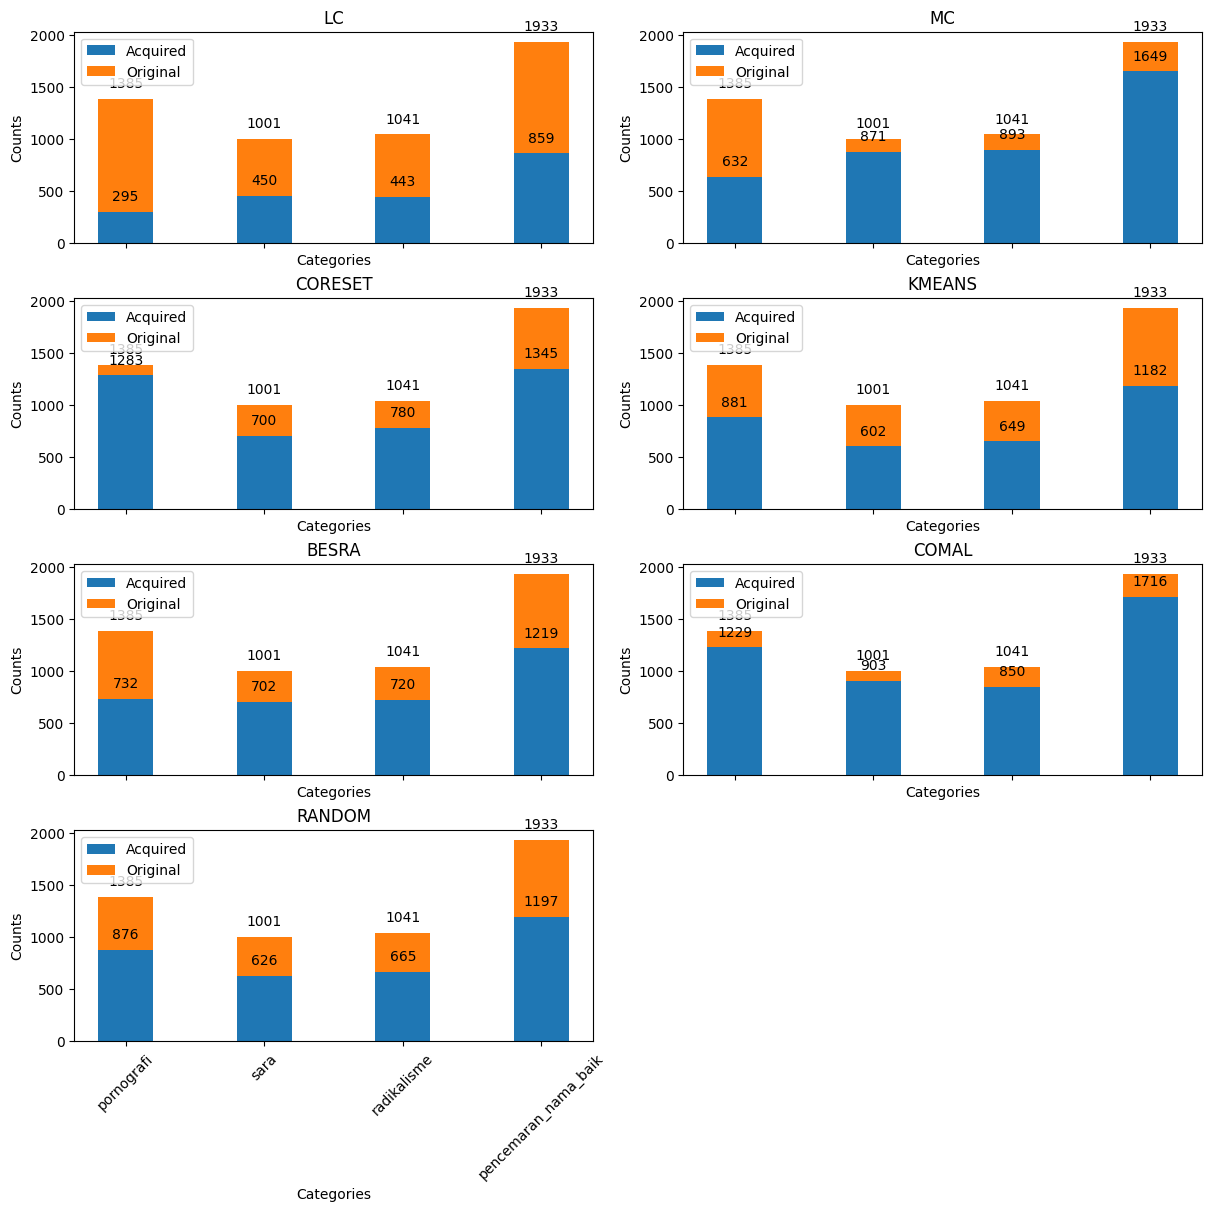

In [22]:
differences = []

for strategy in strategies:
    print(f"Processing strategy: {strategy}")
    acq_data, ori_data, label_columns = load_data('netifier', strategy.lower(), 0.5)
    acq_label_count, ori_label_count, difference = count_difference(acq_data, ori_data, label_columns, None)

    differences.append(difference)

    # Specify the columns to analyze
    columns_to_analyze = hyperparams['netifier']['labels']

    # Calculate imbalance ratios for each column
    imbalance_ratios = {col: calculate_imbalance_ratio(acq_data[col]) for col in columns_to_analyze}

    # Calculate the mean imbalance ratio
    mean_imbalance_ratio = round(sum(imbalance_ratios.values()) / len(imbalance_ratios), 2)

    # Print the results
    print("Imbalance Ratios for each column:", imbalance_ratios)
    print("Mean Imbalance Ratio:", mean_imbalance_ratio)
    print("-----------------------------------------------------")

plot_acquired_data(differences, label_columns)

Processing strategy: LC
{'HS_Religion': 307, 'HS_Race': 242, 'HS_Physical': 52, 'HS_Gender': 47}
{'HS_Religion': 641, 'HS_Race': 453, 'HS_Physical': 252, 'HS_Gender': 256}
Imbalance Ratios for each column: {'HS': 3.430686406460296, 'Abusive': 4.5467565290648695, 'HS_Individual': 7.108374384236453, 'HS_Group': 8.768545994065281, 'HS_Religion': 20.446254071661237, 'HS_Race': 26.206611570247933, 'HS_Physical': 125.61538461538461, 'HS_Gender': 139.08510638297872, 'HS_Other': 6.447963800904978, 'HS_Weak': 7.408684546615581, 'HS_Moderate': 11.036563071297989, 'HS_Strong': 41.205128205128204}
Mean Imbalance Ratio: 33.44
-----------------------------------------------------
Processing strategy: MC
{'HS_Religion': 587, 'HS_Race': 441, 'HS_Physical': 228, 'HS_Gender': 238}
{'HS_Religion': 641, 'HS_Race': 453, 'HS_Physical': 252, 'HS_Gender': 256}
Imbalance Ratios for each column: {'HS': 1.4020430499817584, 'Abusive': 1.0221130221130221, 'HS_Individual': 1.7421907538525614, 'HS_Group': 3.56588072

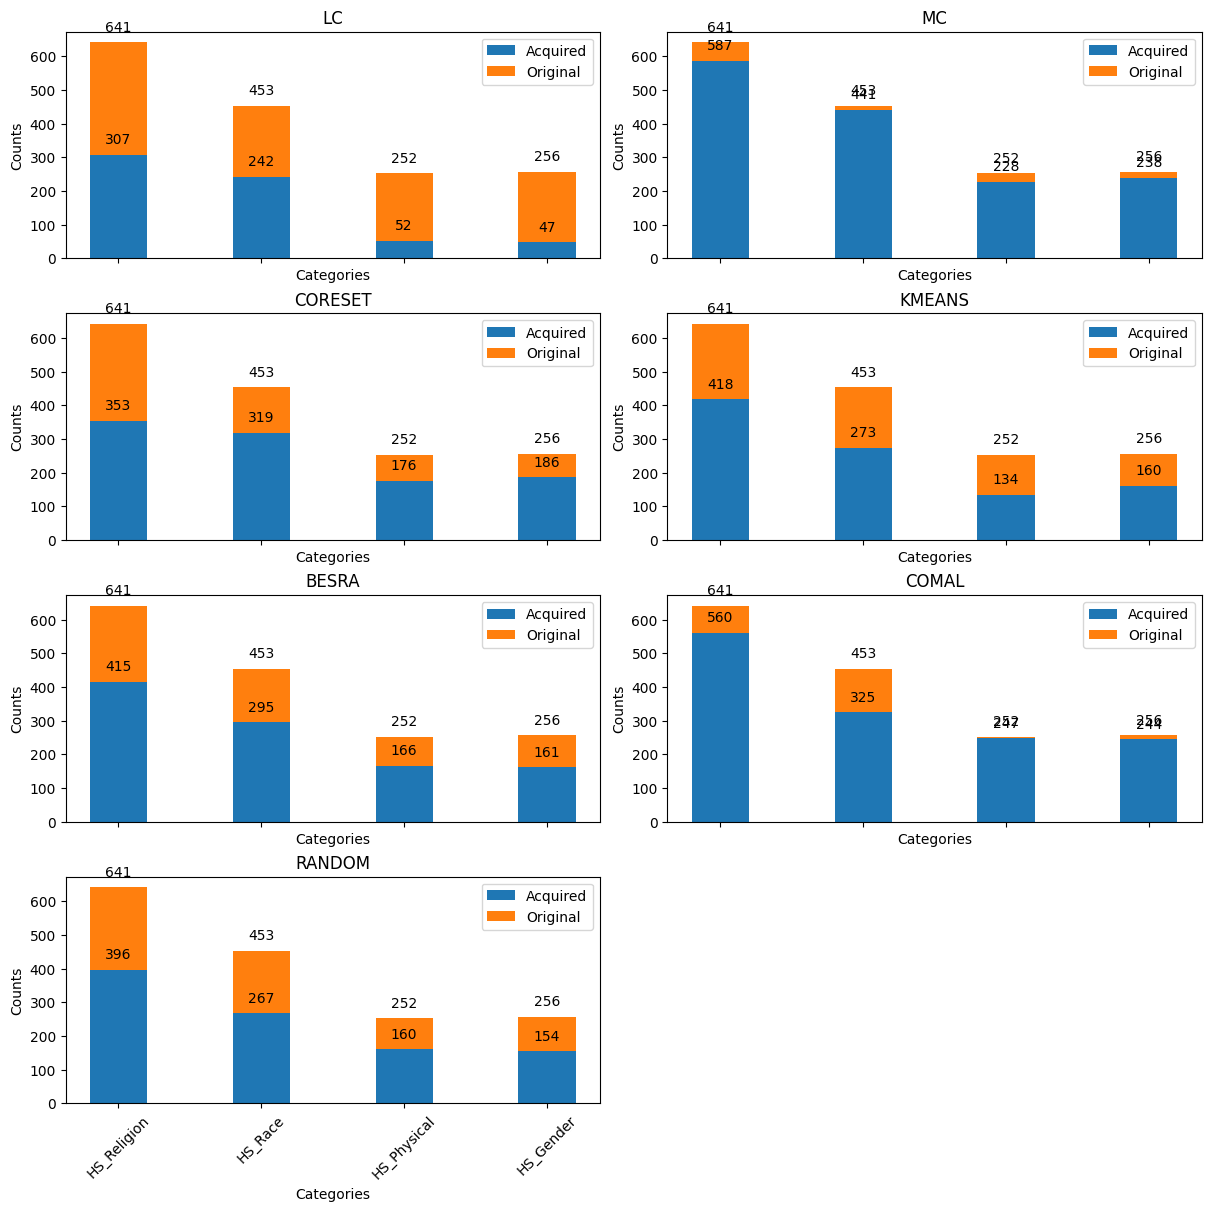

In [23]:
differences = []

for strategy in strategies:
    print(f"Processing strategy: {strategy}")
    acq_data, ori_data, label_columns = load_data('hsd', strategy.lower(), 0.5)
    label_columns = ['HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender']
    acq_label_count, ori_label_count, difference = count_difference(acq_data, ori_data, label_columns)
    differences.append(difference)

    # Specify the columns to analyze
    columns_to_analyze = hyperparams['hsd']['labels']

    # Calculate imbalance ratios for each column
    imbalance_ratios = {col: calculate_imbalance_ratio(acq_data[col]) for col in columns_to_analyze}

    # Calculate the mean imbalance ratio
    mean_imbalance_ratio = round(sum(imbalance_ratios.values()) / len(imbalance_ratios), 2)

    # Print the results
    print("Imbalance Ratios for each column:", imbalance_ratios)
    print("Mean Imbalance Ratio:", mean_imbalance_ratio)
    print("-----------------------------------------------------")

plot_acquired_data(differences, label_columns)